In [1]:
from data_reader import Vocabulary, HWDBDatasetHelper, ArchivedHWDBReader

# your path to data
train_path = r'/media/artem/A2F4DEB0F4DE85C7/myData/datasets/HWDBT/train.zip'
test_path = r'/media/artem/A2F4DEB0F4DE85C7/myData/datasets/HWDBT/test.zip'
gt_path = './gt.txt'

# Simple CNN baseline

pytorch is required for this baseline implementation

## Baseline method

- Naively resize to 32x32 (DON'T DO THIS IN YOUR WORK, try to save geometry somehow, it is important)
- Train LeNet-like CNN
- Enjoy :)

In [2]:
import cv2
import numpy as np

### Data tools

In [3]:
train_reader = ArchivedHWDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

### Model & training

In [6]:
!pip install pytorch-metric-learning
!pip install umap-learn

In [7]:
from torchvision import models
from torch import nn

model = models.mobilenet_v3_small(pretrained=True)
                      
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [8]:
from torch.utils.data import Dataset, DataLoader

def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            _, probs = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(probs, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all

def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    model.train()

    for batch, (X, y) in enumerate(tqdm(train_loader)):
                
        features = model( X.to(torch.float32).cuda() )      
        loss = loss_fn(features, y.to(torch.long).cuda()) 

        optim[0].zero_grad()
        optim[1].zero_grad()
        
        loss.backward()

        optim[0].step()
        optim[1].step()
        

In [9]:

class MyHWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        hi, wi = img.shape
        
        size = 64
        while hi < size and wi < size:
            hi = hi * 2
            wi = wi * 2
        
        while hi > size or wi > size:
            hi = hi // 2
            wi = wi // 2
            
        img = cv2.resize(img, (wi, hi))

        frame = np.zeros((3, size, size)) + 255
        
        h, w = img.shape
        
        frame[0, :h, :w] = img.copy()
        frame[1, :h, :w] = img.copy()
        frame[2, :h, :w] = img.copy()
        
        return (frame - 127.5) / 255., label

train_dataset = MyHWDBDataset(train_helper)
val_dataset = MyHWDBDataset(val_helper)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

In [11]:
from pytorch_metric_learning import losses
import torch

loss_emb = losses.ArcFaceLoss(num_classes=train_helper.vocabulary.num_classes(), embedding_size=1000).to(torch.device('cuda'))
loss_optimizer = torch.optim.Adam(loss_emb.parameters(), lr=1e-3)

loss_fn = loss_emb
optim = [torch.optim.Adam(model.parameters(), lr=1e-3), loss_optimizer]


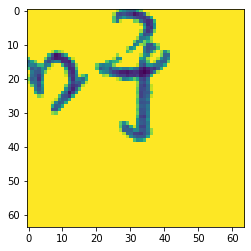

In [12]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0][0])
plt.show()
#print(train_dataset[0][0].shape)
#model(torch.tensor(train_dataset[0][0], dtype=torch.float32).unsqueeze(0))


In [13]:
model = model.cuda()

In [14]:
from tqdm import tqdm

for epoch in range(1):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'baseline_epoch{epoch}.pth')

    

Epoch 0:


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1667/2518 [15:23<07:51,  1.80it/s]


KeyboardInterrupt: 

In [15]:
torch.save(loss_fn.state_dict(), f'loss0.pth')
torch.save(model.state_dict(), f'baseline_epoch0.pth')

In [16]:
test_path = r'/media/artem/A2F4DEB0F4DE85C7/myData/datasets/HWDBT/test.zip'
pred_path = './pred.txt'

test_reader = ArchivedHWDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [17]:
test_dataset = MyHWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [20]:
from tqdm import tqdm

preds = []

model = models.mobilenet_v3_small(pretrained=True)
PATH = "/home/artem/PycharmProjects/course_ocr/course_ocr/task2/baseline_epoch0.pth"
model.load_state_dict(torch.load(PATH))
model.eval().cuda()

loss_fn = losses.ArcFaceLoss(num_classes=train_helper.vocabulary.num_classes(), embedding_size=1000).to(torch.device('cuda'))
PATH = "/home/artem/PycharmProjects/course_ocr/course_ocr/task2/loss0.pth"
loss_fn.load_state_dict(torch.load(PATH))
loss_fn.eval().cuda()


with torch.no_grad():
    for X, _ in tqdm(test_loader):
        
        embeddings = model(X.to(torch.float32).cuda())
        logits = loss_fn.get_logits(embeddings)
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [03:21<00:00,  1.89it/s]


In [21]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [22]:
from pathlib import Path

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path) as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls
    
    n_good = 0
    n_all = len(gt)
    with open(pred_path) as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1
    
    return n_good / n_all


def _run_evaluation():
    base = Path("/home/artem/PycharmProjects/course_ocr/course_ocr/task2")
    gt_path = base / 'gt.txt'
    pred_path = base / 'pred.txt'
    score = evaluate(gt_path, pred_path)
    print('Accuracy = {:1.4f}'.format(score))

_run_evaluation()

Accuracy = 0.2872
